# Pokemon - Base Stats and Types
**Description**: Is there a correlation between a Pokemon's Defense stat and it's height or weight?

<img src="https://github.com/Mushtatoes/proj/blob/master/pikachu.png?raw=true" width="300"/>


---
>- Defense is one of the primary stats used during combat in Pokemon. It is one of the fundamental values used in the core combative gameplay of Pokemon.<br>
- Weight and Height are go more or less unnoticed in Pokemon games. They're mostly fun facts that exist in the Pokedex. It's highly unlikely that developers look at Defense and Weight/Height in parallel when creating Pokemon.<br>
- There are Pokemon like Onix and Steelix, both of which have positively correlated Defense and Weight or Height, but then there are Pokemon like Shuckle...a tiny and light Pokemon with even higher Defense than the two mentioned.<br>
- This study will calculate the correlation coefficient between Defense and Weight and determine if these properties have any relationship with each other.




In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import requests
import re

## 1. Obtaining Data


>- No mega-evolutions, alternate forms, etc.
- Pulling from PokeAPI
- Manually parse and add data into Dataframe without using read_json
- At time of writing, there are currently 807 unique Pokemon in the API (Up to Gen 7)




In [0]:
pokemon_json = requests.get('https://pokeapi.co/api/v2/pokemon?&limit=5000').json()
# print(pokemon_json)

#### 1a. Filter out non-standard Pokemon by id:
>- Create a list of urls that can be used to pull data on each Pokemon.
- PokeAPI uses id <= 10000 to identify standard Pokemon and their traits.
- Use regular expressions to isolate the id from the url and compare.

In [0]:
name_url_raw = pokemon_json['results']

# Filter out non-standard Pokemon using regex on url:
def pokemon_filter(pokemon_object):
  pokemon_search = re.search('^https://pokeapi\.co/api/v2/pokemon/(\d+)/$', pokemon_object['url'])
  if not pokemon_search:
    return False
  return int(pokemon_search.group(1)) <= 10000

name_url = list(filter(pokemon_filter, name_url_raw))

pokemon_urls = [x['url'] for x in name_url]


#### 1b. Map the required data:
>- Each Pokemon's base stats can only be found on their own page, which means a request for each Pokemon.
- Storing into a flat file or SQL table would be preferable if the data is  required for reuse in the future.

In [0]:
# Return each pokemon's name, type1, and base stats:
def pokemon_map(url):
  pokemon = requests.get(url).json()
  data = {'name': pokemon['name']
          ,'type1': ''.join([t['type']['name'] for t in pokemon['types'] if t['slot'] == 1])
          ,'stats': {s['stat']['name']: s['base_stat']for s in pokemon['stats']}
          ,'weight': pokemon['weight']
          ,'height': pokemon['height']
          }
  return data

# Type1 and stats are not required here: pulled in the case this data needs to be re-used for other tests 
pokemon_data = list(map(pokemon_map, pokemon_urls))

#print(pokemon_data)

#### 1c. Push the data into a pandas DataFrame:

In [0]:
# Format data into dictionaries for DataFrame:
# {Header: [data]}

def pivot_data(category, subcategory = None):
  if not subcategory:
    return [pokemon[category] for pokemon in pokemon_data]
  else:
    return [pokemon[category][subcategory] for pokemon in pokemon_data]

pokemon_name = pivot_data('name')
pokemon_type = pivot_data('type1')
pokemon_spd = pivot_data('stats', 'speed')
pokemon_spdef = pivot_data('stats', 'special-defense')
pokemon_spatk = pivot_data('stats', 'special-attack')
pokemon_def = pivot_data('stats', 'defense')
pokemon_atk = pivot_data('stats', 'attack')
pokemon_hp = pivot_data('stats', 'hp')
pokemon_weight = pivot_data('weight')
pokemon_height = pivot_data('height')

pokemon_df = pd.DataFrame({'Name': pokemon_name
                           ,'Type1': pokemon_type
                           ,'SPD': pokemon_spd
                           ,'SPDEF': pokemon_spdef
                           ,'SPATK': pokemon_spatk
                           ,'DEF': pokemon_def
                           ,'ATK': pokemon_atk
                           ,'HP': pokemon_hp
                           ,'Weight': pokemon_weight
                           ,'Height': pokemon_height
                           })

# Display top rows from DataFrame for preview:

pokemon_df.head()

,Name,Type1,SPD,SPDEF,SPATK,DEF,ATK,HP,Weight,Height
0,bulbasaur,grass,45,65,65,49,49,45,69,7
1,ivysaur,grass,60,80,80,63,62,60,130,10
2,venusaur,grass,80,100,100,83,82,80,1000,20
3,charmander,fire,65,50,60,43,52,39,85,6
4,charmeleon,fire,80,65,80,58,64,58,190,11


## 2. Testing the Relationships



#### 2a. Viewing and Calculating Data
> Test the impact of each pokemon property versus it's Defense stat:
 - DEF vs. Weight
 - DEF vs. Height
 - Weight vs. Height

Let's see how each set looks on separate plots:


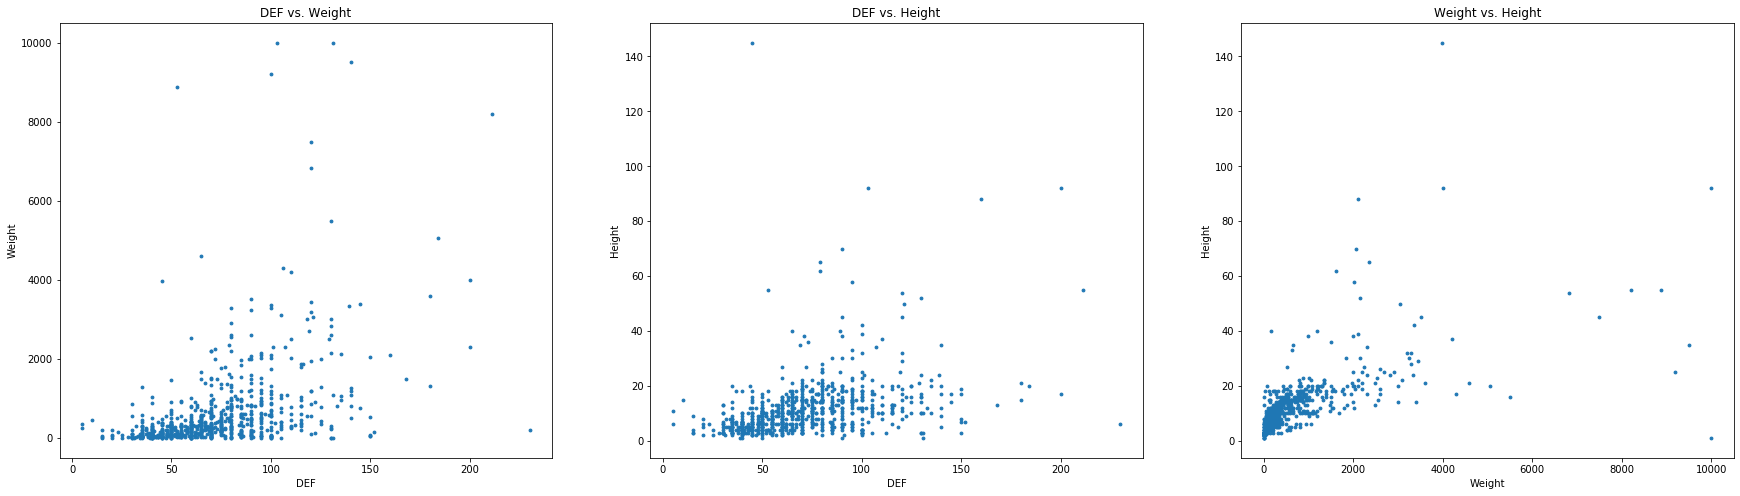

In [118]:
fig, ax = plt.subplots(1,3, figsize = (30,8))

def scatter_grapher(df, i, prop_x, prop_y):
  ax[i].scatter(df[prop_x], df[prop_y], s = 8)
  ax[i].set_title(prop_x + ' vs. ' + prop_y)
  ax[i].set_xlabel(prop_x)
  ax[i].set_ylabel(prop_y)

scatter_grapher(pokemon_df, 0, 'DEF', 'Weight')
scatter_grapher(pokemon_df, 1, 'DEF', 'Height')
scatter_grapher(pokemon_df, 2, 'Weight', 'Height')

plt.show()

For future calculations, we're going to need the standard deviation. 

The mean will be covered when using the covariance method.

In [0]:
# Calculate standard deviation using DataFrame method:
height_sig = pokemon_df.Height.std()
def_sig = pokemon_df.DEF.std()
weight_sig = pokemon_df.Weight.std()

pokemon_df.head()

,Name,Type1,SPD,SPDEF,SPATK,DEF,ATK,HP,Weight,Height
0,bulbasaur,grass,45,65,65,49,49,45,69,7
1,ivysaur,grass,60,80,80,63,62,60,130,10
2,venusaur,grass,80,100,100,83,82,80,1000,20
3,charmander,fire,65,50,60,43,52,39,85,6
4,charmeleon,fire,80,65,80,58,64,58,190,11


#### 2b. Calculating the Correlation Coefficient

We can compare the how much each property is related each other using the correlation coefficient, denoted by ρ (rho).
> - 1 = Positive Correlation
- 0 = No Correlation
--1 = Negative Correlation

Let's create a function that can calculate the coefficient.

In [0]:
# Covariance can easily be calculated using .cov() and retrieving the desired value from the cell in the covariance matrix.
def tot_rho_calc(prop1, prop2):
  cov_matrix = pokemon_df[[prop1, prop2]].cov()
  cov = cov_matrix[prop1][1]
  rho = cov/((globals()[prop1.lower() + '_sig']) * (globals()[prop2.lower() + '_sig']))
  return rho

In [129]:
print('DEF & Weight: ')
print(tot_rho_calc('DEF', 'Weight'))
print()
print('DEF & Height: ')
print(tot_rho_calc('DEF', 'Height'))
print()
print('Weight & Height: ')
print(tot_rho_calc('Weight', 'Height'))

DEF & Weight: 
0.4469915593837378

DEF & Height: 
0.3627745511097767

Weight & Height: 
0.6364209470932939


#### 2c. Thoughts and Analysis



There is a moderate positive correlation for DEF and Weight/Height, but not enough to make any assumptions that DEF is affected by those properties.

>Weight and Height, both which are less important to gameplay and more arbitrary properties in the Pokemon universe, have a higher correlation coefficient than the other two tests. It makes logical sense that the taller a Pokemon becomes, the heavier it will become. 

>Another reason the Weight & Height correlation coefficient may be higher is because those two values likely come from the same source: the Pokemon creators. DEF is a combat stat used in core gameplay, so it has to be balanced and maintained based on how the game developers feel fit, while Weight and Height have a very low impact on the core gameplay.

## 3. Filtering by Type

The analysis in section 2 was used with all Pokemon that currently exist in the PokeAPI (Gen 7).

Let's find the top Defense-based Pokemon type and use it for correlation anaylsis.

> - There are currently 18 types of Pokemon.
> - Only Type1 will be used, as that is the Pokemon's primary type.
> - Find the top type where DEF is the highest stat per Pokemon.

#### 3a. Creating a new DataFrame for DEF-based Pokemon

In [33]:
def def_bin(row):
  return pokemon_df.DEF.iloc[row] == pokemon_df[['SPD','SPDEF','SPATK','DEF','ATK','HP']].iloc[row].max()


pokemon_df['def_hi'] = [def_bin(pokemon) for pokemon in range(pokemon_df.Name.count()) if True]

def_pokemon_df = pokemon_df[pokemon_df.def_hi == True]

def_pokemon_df

,Name,Type1,SPD,SPDEF,SPATK,DEF,ATK,HP,Weight,Height,def_hi
6,squirtle,water,43,64,50,65,48,44,90,5,True
7,wartortle,water,58,80,65,80,63,59,225,10,True
10,metapod,bug,30,25,25,55,20,50,99,7,True
13,kakuna,bug,35,25,25,50,25,45,100,6,True
26,sandshrew,ground,40,30,20,85,75,50,120,6,True
...,...,...,...,...,...,...,...,...,...,...,...
782,hakamo-o,dragon,65,70,65,90,75,55,470,12,True
783,kommo-o,dragon,85,105,100,125,110,75,782,16,True
789,cosmoem,psychic,37,131,29,131,29,43,9999,1,True
793,buzzwole,bug,79,53,53,139,139,107,3336,24,True


Now that we have all the Defense-based Pokemon, not all types have the same number of Pokemon, so the proportion of Pokemon that are Defense-based per type will be taken out of all Pokemon per type.

> - If there are other stats equal to DEF as the highest, they are still counted as a Defensive Pokemon.

In [80]:
tot_count = pokemon_df.groupby('Type1').count()
def_count = def_pokemon_df.groupby('Type1').count()

df_prop = pd.DataFrame(round(def_count['Name'] / tot_count['Name'], 2))

rename_df = df_prop.rename(columns = {'Name': 'Proportion'})

def_type_prop = rename_df.reset_index()

def_type_prop

,Type1,Proportion
0,bug,0.33
1,dark,0.10
2,dragon,0.19
3,electric,NaN
4,fairy,0.17
5,fighting,0.03
6,fire,0.06
7,flying,NaN
8,ghost,0.37
9,grass,0.21


#### 3b. Determining which Type to Test

Plot on a bar graph so that the highest proportion of defense-based Pokemon types can easily be compared.

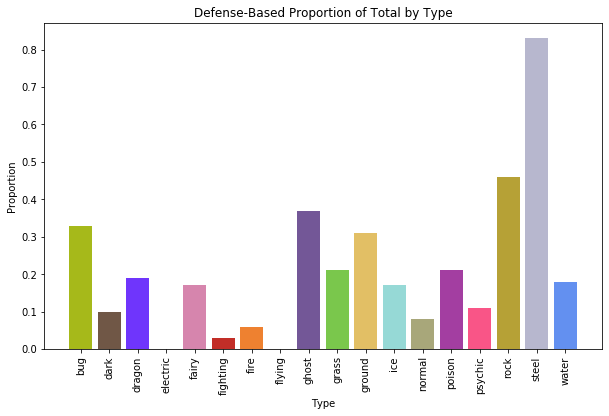

In [102]:
# HTML color codes for each type
type_colors = {'bug': '#A6B91A', 'dark': '#705746', 'dragon': '#6F35FC', 'electric': '#F7D02C', 'fairy': '#D685AD', 'fighting': '#C22E28'
, 'fire': '#EE8130', 'flying': '#A98FF3', 'ghost': '#735797', 'grass': '#7AC74C', 'ground': '#E2BF65', 'ice': '#96D9D6'
, 'normal': '#A8A77A', 'poison': '#A33EA1', 'psychic': '#F95587', 'rock': '#B6A136', 'steel': '#B7B7CE', 'water': '#6390F0'}

# Set x/y positions and create labels
x = range(def_type_prop.Type1.count())
y = def_type_prop.Proportion
xlabels = list(def_type_prop.Type1)

plt.figure(figsize = (10,6))
plt.bar(x, y, color = type_colors.values())
plt.xticks(x, xlabels, rotation = 90)
plt.xlabel('Type')
plt.ylabel('Proportion')
plt.title('Defense-Based Proportion of Total by Type')

plt.show()

#### 3c. Calculating the Correlation Coefficient for Steel types

We can see that Steel has a resounding top proportion of Defense based Pokemon, with Rock coming in second and Ghost coming in third.

>- Note that ghost types have the third highest proportion of Defense-based Pokemon.
- Most ghost Pokemon have little to no Weight, which could have been part of the reason why the DEF to Weight correlation coefficient was moderate.
- Keep in mind these are primary types only:

Plotting Steel Pokemon for the same properties tested earlier:

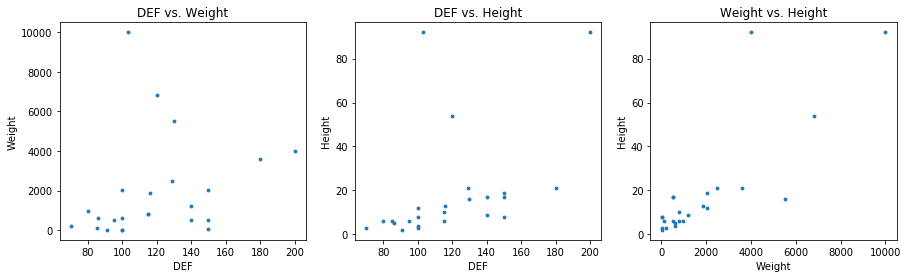

In [122]:
steel_df = pokemon_df[pokemon_df.Type1 == 'steel']

fig, ax = plt.subplots(1,3, figsize = (15,4))

scatter_grapher(steel_df, 0, 'DEF', 'Weight')
scatter_grapher(steel_df, 1, 'DEF', 'Height')
scatter_grapher(steel_df, 2, 'Weight', 'Height')

plt.show()

Besides the outliers, the plots are looking somewhat more linear.

Let's calculate the correlation coefficient to find out more:

In [133]:
steel_def_sig = steel_df.DEF.std()
steel_weight_sig = steel_df.Weight.std()
steel_height_sig = steel_df.Height.std()


def steel_rho_calc(prop1, prop2):
  cov_matrix = steel_df[[prop1, prop2]].cov()
  cov = cov_matrix[prop1][1]
  rho = cov/((globals()['steel_' + prop1.lower() + '_sig']) * (globals()['steel_' + prop2.lower() + '_sig']))
  return rho

print('DEF & Weight: ')
print(steel_rho_calc('DEF', 'Weight'))
print()
print('DEF & Height: ')
print(steel_rho_calc('DEF', 'Height'))
print()
print('Weight & Height: ')
print(steel_rho_calc('Weight', 'Height'))

DEF & Weight: 
0.2540976056692535

DEF & Height: 
0.4496068926839539

Weight & Height: 
0.8149272635763696


>- DEF & Weight turn out to be have even less correlation than before. <br>
- DEF & Height seems about the same as for all Pokemon.<br>
- Weight & Height look like they have a pretty high level of correlation.
-This is most likely due to a combination of the smaller sample size and some huge outliers that influence the coefficient.

Pokemon like Celesteela, Dialga, Metagross, Jirachi, Honedge, and Doublade are outliers that have a significant impact on the data. 

As said before, Pokemon weights and heights are for mostly for canonical purposes and not gameplay purposes. <br>
Celesteela has 9999 Weight, which translates to half a ton! <br>
It seems like the developers were trying to throw a fun fact out for their players by making a Pokemon so heavy. 


## **Conclusion**: 

We can conclude that there is no significant correlation between a Pokemon's DEF stat and its Height or Weight.

Main reasons would be:

- DEF is a combat stat, Height and Weight are almost never used in combat.
- Outlier Pokemon (mainly legendaries and pseudo-legendaries) have strange heights and weights but normal DEF stats for combat purposes.
- Gameplay and canonical facts should be kept separate in gameplay design, otherwise we would have Pokemon like Celesteela who would have infinite Defense and be almost impossible to defeat!

Thanks for reading!